**D3APL: Aplicações em Ciência de Dados** <br/>
IFSP Campinas

Renata Rabelo e Mariana Cabride

Prof. Dr. Samuel Martins (Samuka) <br/><br/>

**Descrição:** Nesse notebook estamos usando uma Convolutional Neural Network (CNN) customizada, construída utilizando a interface Sequential do Keras. Ela possuía duas camadas convolucionais, seguidas por camadas de pooling, uma camada de achatamento (flatten) e duas camadas densas (fully connected)

### **Carregando as bibliotecas**

 TensorFlow, os, pandas, numpy e random são importados. Essas bibliotecas são usadas para manipulação de dados, treinamento de redes neurais e outras operações relacionadas.

In [45]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

### **Configuração dos seeds aleatórios**

Função reset_random_seeds(): Essa função configura as sementes aleatórias para garantir a reprodutibilidade dos resultados. Ela define as sementes para TensorFlow, NumPy e Python's Random.

In [2]:
def reset_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

reset_random_seeds()

### **Montagem do Google Drive**

O código monta o Google Drive para acessar os arquivos de dados. Ele usa a biblioteca do Google Colab para essa finalidade.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Carregamento dos dados**

Os arquivos de treinamento e teste são carregados usando o pandas. Eles são armazenados em dataframes (dataset_df_train_completo e dataset_df_test, respectivamente). Após essa etapa, é feita a conversão dos rótulos das classes de formato de texto para números inteiros usando o LabelEncoder.

In [4]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Kaggle/ifsp-d3apl-2023-face-recognition'
train_file = os.path.join(data_dir, 'train.csv')
test_file = os.path.join(data_dir, 'test.csv')

dataset_df_train_completo = pd.read_csv(train_file)
dataset_df_test = pd.read_csv(test_file)

# Conversão dos rótulos em formato de texto para números inteiros
label_encoder = LabelEncoder()
dataset_df_train_completo["label"] = label_encoder.fit_transform(dataset_df_train_completo["label"])

### **Divisão do conjunto de treinamento completo em treinamento e validação**

O conjunto de treinamento completo (dataset_df_train_completo) é dividido em conjuntos de treinamento e validação usando a função train_test_split do scikit-learn. Os dados são divididos em uma proporção de 80% para treinamento e 20% para validação. A variável labels contém as classes de destino.

In [5]:
labels = dataset_df_train_completo["label"]
dataset_df_train, dataset_df_val = train_test_split(dataset_df_train_completo, test_size=0.2, random_state=42, stratify=labels)

### **Construção da arquitetura da rede neural convolucional**

A função build_cnn é definida para construir uma arquitetura de rede neural convolucional. Ela utiliza a API Sequential do Keras para criar a sequência de camadas da rede. A arquitetura consiste em camadas convolucionais, camadas de pooling, camadas flatten e camadas totalmente conectadas. A função de ativação 'relu' é usada nas camadas convolucionais e nas camadas totalmente conectadas.

No final do código, o modelo é compilado com a função de perda 'sparse_categorical_crossentropy', o otimizador SGD e a métrica de avaliação 'accuracy'.

In [6]:
def build_cnn(input_shape=(64, 64, 3), n_classes=10):
    model = Sequential([
        Conv2D(filters=32, kernel_size=(4,4), activation='relu', input_shape=input_shape),
        MaxPool2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    return model

input_shape = (100, 100, 3)
n_classes = 83

model = build_cnn(input_shape, n_classes)
opt = SGD(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 97, 97, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 15488)             0         
                                                                 
 dense (Dense)               (None, 256)               3

### **Pré-processamento dos dados**

A função preprocess_faces_dataset é definida para pré-processar os dados de imagem. Ela itera sobre o dataframe do dataset de treinamento ou validação, carrega cada imagem usando a função load_img do Keras, redimensiona para o tamanho desejado, converte para um array NumPy e normaliza os valores dos pixels dividindo por 255. O resultado é um array de imagens (X) e um array de rótulos (y).

In [7]:
def preprocess_faces_dataset(dataset_df, input_shape=(64, 64), verbose=0):
    image_list = []
    label_list = []

    for index, row in dataset_df.iterrows():
        img_path = os.path.join(data_dir, 'train', row['image-pathname'])
        img = load_img(img_path, target_size=input_shape)
        img = img_to_array(img) / 255.0
        image_list.append(img)
        label_list.append(row['label'])

        if verbose and (index % verbose) == 0:
            print(f'{index + 1}/{len(dataset_df)} - {img_path}')

    X = np.array(image_list)
    y = np.array(label_list)

    return X, y

Os conjuntos de treinamento e validação são pré-processados usando a função preprocess_faces_dataset.

In [8]:
X_train, y_train = preprocess_faces_dataset(dataset_df_train, input_shape)
X_val, y_val = preprocess_faces_dataset(dataset_df_val, input_shape)

### **Callbacks**

No código abaixo é feita a definição dos callbacks early_stopping_cb e tensorboard_callback para monitorar o treinamento e evitar overfitting.

In [9]:
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir='logs/')

## **Treinamento do modelo**

Treinamento do modelo usando o método fit, passando os dados de treinamento e validação, número de epochs, tamanho do lote e callbacks

In [10]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb, tensorboard_callback])

Epoch 1/100
244/244 [==============================] - 101s 409ms/step - loss: 4.3652 - accuracy: 0.0300 - val_loss: 4.3263 - val_accuracy: 0.0334
Epoch 2/100
244/244 [==============================] - 92s 379ms/step - loss: 4.2904 - accuracy: 0.0436 - val_loss: 4.2592 - val_accuracy: 0.0575
Epoch 3/100
244/244 [==============================] - 96s 396ms/step - loss: 4.1602 - accuracy: 0.0625 - val_loss: 4.0864 - val_accuracy: 0.0918
Epoch 4/100
244/244 [==============================] - 93s 380ms/step - loss: 3.9675 - accuracy: 0.0906 - val_loss: 3.9604 - val_accuracy: 0.1108
Epoch 5/100
244/244 [==============================] - 95s 390ms/step - loss: 3.7543 - accuracy: 0.1206 - val_loss: 3.8075 - val_accuracy: 0.1144
Epoch 6/100
244/244 [==============================] - 97s 399ms/step - loss: 3.5056 - accuracy: 0.1659 - val_loss: 3.5233 - val_accuracy: 0.1780
Epoch 7/100
244/244 [==============================] - 94s 385ms/step - loss: 3.1561 - accuracy: 0.2317 - val_loss: 3.2601 

#### **Visualizando o histórico de treinamento**

O código abaixo cria um DataFrame do pandas chamado history_df a partir do objeto history.history, que contém as métricas de treinamento e validação ao longo das épocas durante o treinamento do modelo.

Em seguida, são plotados dois gráficos. O primeiro gráfico mostra as curvas de perda (loss) de treinamento e validação ao longo das épocas. O eixo x representa as épocas e o eixo y representa a perda. O segundo gráfico mostra as curvas de acurácia (accuracy) de treinamento e validação ao longo das épocas. O eixo x representa as épocas e o eixo y representa a acurácia.

Esses gráficos ajudam a visualizar o desempenho do modelo durante o treinamento e a analisar a convergência e o overfitting. A função plot do pandas é usada para traçar os gráficos e as funções grid, xlabel e ylabel do matplotlib.pyplot são usadas para adicionar a grade e rótulos aos eixos dos gráficos.

Text(0, 0.5, 'Score')

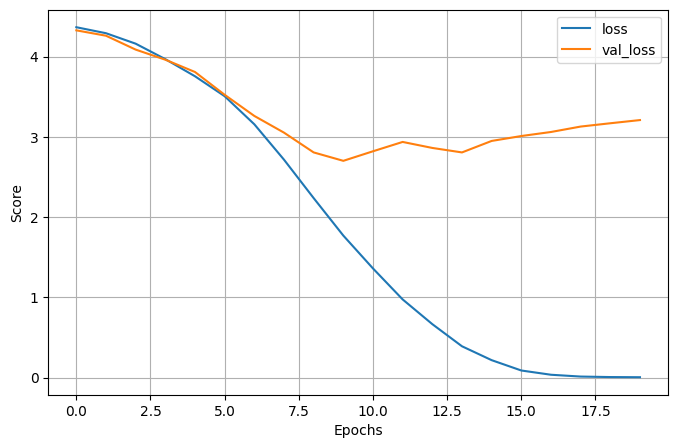

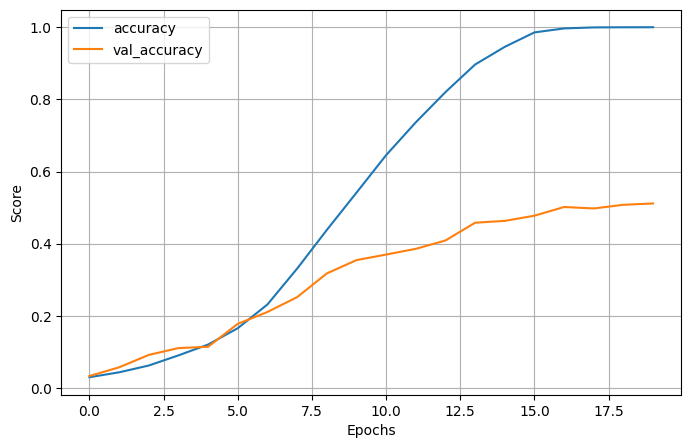

In [13]:
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')

### **Salvando o modelo treinado**

O modelo treinado está sendo salvo em um arquivo HDF5

In [14]:
model.save('model.h5')

### **Criação do diretório de saída para salvar os conjuntos de dados pré-processados**

O código abaixo faz a criação de um diretório de saída, e na sequencia, o salvamento dos conjuntos de dados e arquivos numpy pré-processados

In [15]:
out_dir = '/content/drive/MyDrive/Colab Notebooks/Kaggle/preprocessed_02'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

dataset_df_train_completo.to_csv(os.path.join(out_dir, 'full_train.csv'), index=False)
dataset_df_train.to_csv(os.path.join(out_dir, 'train.csv'), index=False)
dataset_df_val.to_csv(os.path.join(out_dir, 'validation.csv'), index=False)

np.save(os.path.join(out_dir, 'X_train.npy'), X_train)
np.save(os.path.join(out_dir, 'y_train.npy'), y_train)
np.save(os.path.join(out_dir, 'X_val.npy'), X_val)
np.save(os.path.join(out_dir, 'y_val.npy'), y_val)

### **Montando o arquivo de submissão**



In [35]:
# Define uma função chamada read_test para ler e pré-processar as imagens de teste
def read_test(dataset_df, input_shape=(64, 64), verbose=0):
    image_list = []
    label_list = []

    for index, row in dataset_df.iterrows():
        img_path = os.path.join(data_dir, 'test', row['image-pathname'])
        img = load_img(img_path, target_size=input_shape)
        img = img_to_array(img) / 255.0
        image_list.append(img)

        if verbose and (index % verbose) == 0:
            print(f'{index + 1}/{len(dataset_df)} - {img_path}')

    X = np.array(image_list)

    return X

In [40]:
# Chama a função read_test para carregar e pré-processar as imagens de teste
X_test = read_test(dataset_df_test, input_shape=(100, 100), verbose=1)

1/1660 - /content/drive/MyDrive/Colab Notebooks/Kaggle/ifsp-d3apl-2023-face-recognition/test/test/0001.jpg
2/1660 - /content/drive/MyDrive/Colab Notebooks/Kaggle/ifsp-d3apl-2023-face-recognition/test/test/0002.jpg
3/1660 - /content/drive/MyDrive/Colab Notebooks/Kaggle/ifsp-d3apl-2023-face-recognition/test/test/0003.jpg
4/1660 - /content/drive/MyDrive/Colab Notebooks/Kaggle/ifsp-d3apl-2023-face-recognition/test/test/0004.jpg
5/1660 - /content/drive/MyDrive/Colab Notebooks/Kaggle/ifsp-d3apl-2023-face-recognition/test/test/0005.jpg
6/1660 - /content/drive/MyDrive/Colab Notebooks/Kaggle/ifsp-d3apl-2023-face-recognition/test/test/0006.jpg
7/1660 - /content/drive/MyDrive/Colab Notebooks/Kaggle/ifsp-d3apl-2023-face-recognition/test/test/0007.jpg
8/1660 - /content/drive/MyDrive/Colab Notebooks/Kaggle/ifsp-d3apl-2023-face-recognition/test/test/0008.jpg
9/1660 - /content/drive/MyDrive/Colab Notebooks/Kaggle/ifsp-d3apl-2023-face-recognition/test/test/0009.jpg
10/1660 - /content/drive/MyDrive/Cola

In [41]:
# Faz previsões usando o modelo treinado para as imagens de teste
y_test_proba = model.predict(X_test)
y_test_pred = np.argmax(y_test_proba, axis=1)

# Converte as previsões em rótulos de classe usando label_encoder.inverse_transform
# Cria um DataFrame com as colunas "image-id" e "prediction" e o salva como arquivo CSV
df = pd.DataFrame({"image-id": dataset_df_test["image-id"], "prediction": list(label_encoder.inverse_transform(y_test_pred))})
df.to_csv("results_cnn.csv", index=False)

52/52 [==============================] - 4s 74ms/step


In [44]:
# Repete o processo anterior, salvando o DataFrame em um arquivo chamado "results.csv"
df = pd.DataFrame({"image-id": dataset_df_test["image-id"], "prediction": list(label_encoder.inverse_transform(y_test_pred))})
df.to_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle/results.csv', index=False)